## Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mibian

# Calendar Spread Payoff

A calendar spread strategy profits from the time decay and/or increase in the implied volatility of the options. In this notebook, we will create a payoff graph of the calendar spread at the expiry of the front-month option. In the caldendar speard we make money both from theta and vega. We have vegae exposure sinc ethe vega for buying LT call is higher tahn the vega for ST call. If the ST call expires worthless implied vol does not increase large) and that at teh same time the IV for the LT option increase we make a profit. SO the maximum payoff is obtaiend when teh ST decays completely, expiring at the money, thus retaining all time value of the LT long call.

## Setup
Calendar spread involves options of the same underlying asset, the same strike price but with different expiration dates. 

- Sell a call (or put) with near-term expiration — <font color=blue>“front-month”</font>
- Buy a call (or put) with long-term expiration — <font color=blue>“back-month”</font>

## Calendar spread on Nifty
We will set up the calendar spread on Nifty as shown below.

- Sell 10400 strike call @ INR 50.50 expiring on 28 November 2017 — <font color=blue>“front-month”</font>
- Buy 10400 strike call @ INR 148.50 expiring on 30 December 2017 — <font color=blue>“back-month”</font>

In [ ]:
# Nifty futures price 
nifty_nov_fut = 10350.00
nifty_dec_fut = 10387.00

strike_price = 10400
nov_call_price = 50.50
dec_call_price = 148.50
setup_cost = dec_call_price - nov_call_price

# Today's date is 21 November 2017. Therefore, days to November expiry is 7 days and days to December expiry is 34 days.
days_to_expiry_nov_call = 7
days_to_expiry_dec_call = 34

# Range of values for Nifty
sT = np.arange(0.92*nifty_nov_fut,1.1*nifty_nov_fut, 1) 

# Interest rate for input to Black-Scholes model
interest_rate = 0.0

## Implied volatility

We will calculate the implied volatilities for the front-month and back-month call option using Black-Scholes model. This implied volatility will be later used as input to Black-Scholes model to calculate the call price for diiferent values of Nifty.

In [8]:
# Front-month IV
nov_call_iv = mibian.BS([nifty_nov_fut, strike_price, interest_rate, days_to_expiry_nov_call], 
                        callPrice=nov_call_price).impliedVolatility
print("Front Month IV %.2f" % nov_call_iv,"%")

# Back-month IV
dec_call_iv = mibian.BS([nifty_dec_fut, strike_price, interest_rate, days_to_expiry_dec_call], 
                        callPrice=dec_call_price).impliedVolatility
print("Back Month IV %.2f" % dec_call_iv,"%")

Front Month IV 12.70 %
Back Month IV 12.25 %


## Calculating the call price for front and back month option
Since there are two expiration dates for the options in the calendar spread, Black-Scholes pricing model is used to guesstimate the price of the front-month and back-month 10400 strike call at the front-month call expiry. You may change the days to expiry below to see how payoff changes.

Note: We have assumed that all other things such as implied volatility and interest rates remain constant.

In [ ]:
# Changing days to expiry to a day before the front-month expiry
days_to_expiry_nov_call = 0.001
days_to_expiry_dec_call = 29 - days_to_expiry_nov_call

df = pd.DataFrame()
df['nifty_price'] = sT
df['nov_call_price'] = np.nan
df['dec_call_price'] = np.nan

for i in range(0, len(df)):
    df.at[i,'nov_call_price'] = mibian.BS([df.at[i, 'nifty_price'], strike_price, interest_rate, days_to_expiry_nov_call], 
                                           volatility=nov_call_iv).callPrice
    
    # Since interest rate is considered 0%, 35 is added to the nifty price to get the Nifty December futures price. 
    df.at[i,'dec_call_price'] = mibian.BS([df.at[i, 'nifty_price']+35, strike_price, interest_rate, days_to_expiry_dec_call], 
                                           volatility=dec_call_iv).callPrice
df.head()

,nifty_price,nov_call_price,dec_call_price
0,9522.0,0.0,0.806387
1,9523.0,0.0,0.813929
2,9524.0,0.0,0.821534
3,9525.0,0.0,0.829203
4,9526.0,0.0,0.836937


## Payoff

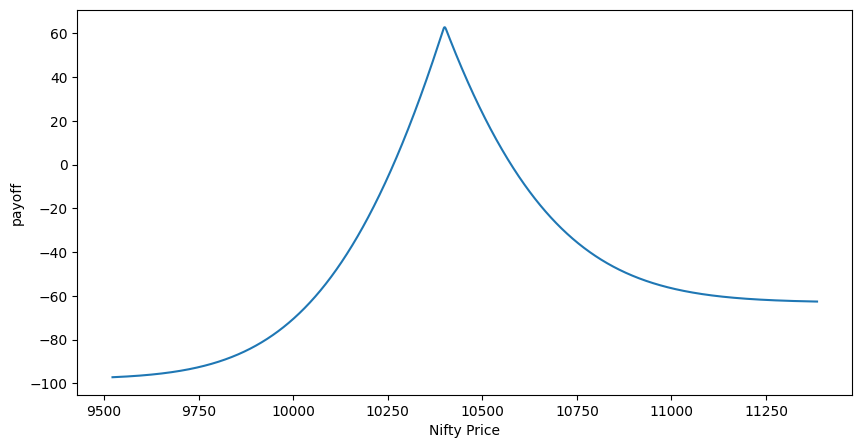

In [22]:
df['payoff'] = df.dec_call_price - df.nov_call_price - setup_cost
plt.figure(figsize=(10,5))
plt.ylabel("payoff")
plt.xlabel("Nifty Price")
plt.plot(sT,df.payoff)
plt.show()

The key takeaways from the graphs are - 

1. The maximum profit is realized when the nifty price on expiry of front-month is at a strike price of INR 10400 
2. The profit decreases as we move away from the strike price of INR 10400 in either direction. 
3. The maximum loss is realized as the option moves deep ITM or deep OTM.

## **Box Spread Arbitrage**

In [1]:
import yfinance as yf
import pandas as pd
from utility import extract_option_chain

path = "spx_options_raw_data/"

expiration = "2014-12-18"

# Fetch options chain
option_chain = extract_option_chain(path, expiration)
option_chain

,bid_call,ask_call,strike,bid_put,ask_put
475189,1050.81,1059.79,100.0,0.05,2.85
475190,955.51,965.20,200.0,0.84,5.40
475191,908.80,919.30,250.0,3.10,7.70
475192,862.40,873.71,300.0,6.00,10.60
475193,816.81,829.21,350.0,9.50,14.21
...,...,...,...,...,...
481625,3.50,5.51,2100.0,878.49,890.51
481626,1.85,3.09,2200.0,974.20,986.20
481627,1.36,2.29,2250.0,1022.50,1034.50
481628,0.39,1.00,2500.0,1265.70,1277.70


In [3]:
# Try box spreads between each pair of strikes
opportunities = []
for i in range(len(option_chain)):
    for j in range(i + 1, len(option_chain)):
        k1 = option_chain.iloc[i]
        k2 = option_chain.iloc[j]

        bull_call_cost = k1['ask_call'] - k2['bid_call']
        bear_put_cost = k2['ask_put'] - k1['bid_put']
        box_cost = bull_call_cost + bear_put_cost
        payoff = k2['strike'] - k1['strike']
        profit = payoff - box_cost

        if profit > 0:
            opportunities.append({
                'K1': k1['strike'],
                'K2': k2['strike'],
                'Box Cost': round(box_cost, 2),
                'Payoff': payoff,
                'Profit': round(profit, 2),
                'Implied Return (%)': round((profit / box_cost) * 100, 2)
            })

# Show top 10 arbitrage opportunities
df = pd.DataFrame(opportunities).sort_values(by='Implied Return (%)', ascending=False)
print(df.head(10))

         K1     K2  Box Cost  Payoff  Profit  Implied Return (%)
515   200.0  250.0     38.26    50.0   11.74               30.68
458   200.0  250.0     38.65    50.0   11.35               29.37
872   250.0  300.0     38.90    50.0   11.10               28.53
815   250.0  300.0     39.40    50.0   10.60               26.90
1220  300.0  350.0     39.41    50.0   10.59               26.87
1163  300.0  350.0     40.02    50.0    9.98               24.94
1563  350.0  400.0     40.51    50.0    9.49               23.43
1506  350.0  400.0     40.81    50.0    9.19               22.52
623   200.0  250.0     41.28    50.0    8.72               21.12
1896  400.0  450.0     41.99    50.0    8.01               19.08
